In [1]:
%matplotlib widget
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stt
from scipy.signal import savgol_filter
import random
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns
import decimal

# Global variables that will remain constant throughout analysis

# Range of delta score (will always be [-1, 1] since scores are percentages between 0-100)
delta_score_range = {'min': 0, 'max': 1}

# Maximum reached score difference
max_score_delta = 0.5

# Effect size (will be changed to )
es = 0.2

# Zone of proximal development (will always be between the range [0,1])
zpd = 0.1

# Range of sample sizes
n = np.arange(40, 330, 40)

# Number of random samples per sample size
N = 150

# Noise deviation
std = 0.2

# Significance value
significance = 0.05


am_a, am_b = (0 - 0.241) / 0.065226, (1 - 0.241) / 0.065226
am_dist = stt.truncnorm(am_a, am_b, loc=0.241, scale=0.065226)


in_a, in_b = (0 - 0.44375) / 0.109799, (1 - 0.44375) / 0.109799
in_dist = stt.truncnorm(in_a, in_b, loc=0.44375, scale=0.109799)

ex_a, ex_b = (0 - 0.777) / 0.074989, (1 - 0.777) / 0.074989
ex_dist = stt.truncnorm(ex_a, ex_b, loc=0.777, scale=0.074989) 

# Returns the deltaScoreImprovement based on the learnerVideoScoreDifference and equation above
def learnerVideoScoreToScoreImprovement(deltaLV, effect_size):
    return (-effect_size * (deltaLV - zpd) ** 2) + max_score_delta

def polynomialModelAndSignificance(X, Y, degree):
    df = pd.DataFrame(columns=['y','x'])
    df['x'] = X
    df['y'] = Y
    results = smf.ols(formula='y ~ x + I(x**2)', data=df).fit()
    return results

def uniformDistributionSample(min_value, max_value, num_of_samples=1):
    range_value = max_value - min_value
    return stt.uniform.rvs(size=num_of_samples) * range_value + min_value

def playerVideoDistributionSample(min_value, max_value, num_of_samples=1):
    _mean = 0.2
    _std = 0.1
    trunc_norm_dist = stt.truncnorm((min_value - _mean) / _std, (max_value-_mean) / _std, loc=_mean, scale=_std)
    #pre_scores = trunc_norm_dist.rvs(num_of_samples)
    pre_scores = uniformDistributionSample(min_value, max_value, num_of_samples)
    
    return_samples = []
    
    for i in range(0, num_of_samples):
        if i % 3 == 0:
            return_samples.append(am_dist.rvs() - pre_scores[i])
        elif i % 3 == 1:
            return_samples.append(in_dist.rvs() - pre_scores[i])
        else:
            return_samples.append(ex_dist.rvs() - pre_scores[i])
    return np.array(return_samples)
    

def generateRegressionData(statistical_test, sample_size, dependent_distribution_sampling,
                           dependent_independent_relation, effect_size, degree, residual_std=0.0,
                           value_range=None):
    # Generate random samples from a distribution for X values (step 1)
    x = dependent_distribution_sampling(value_range['min'], value_range['max'], sample_size)
    
    # Use X values, ground truth function, and some randome noise to generate values for y (steps 2 & 3)
    y = dependent_independent_relation(x, effect_size) + np.random.normal(0, residual_std, sample_size)
    y = [max(value_range['min'], min(value_range['max'], z)) for z in y]
    
    # Fit curve and evaluate F-test p-value (step 4)
    results = statistical_test(x, y, degree)
    
    return x, y, results

def powerAnalysisPolynomialRegression(statistical_test, sample_size_distribution, number_of_samples,
                                      dependent_distribution_sampling, dependent_independent_relation,
                                      effect_size, degree, significance, residual_std=0.0, value_range=None,
                                     show_progress_bar = False):
    """Perform a power analysis of some statistical test.
    
    Keyword arguments:
    statistical_test -- A function that will take in X and Y data and return a poly1d model (numpy),
                        ols results (statsmodels), and a pvalue.
    sample_size_distribution -- A list of all sample sizes to be tested.
    number_of_samples -- The number of samples/tests to be taken per sample size.
    dependent_distribution_sampling -- A function that will return a list of dependent values.
    dependent_independent_relation -- A function returning a list of independent values for some dependent values,
                                      effect size, and residual noise.
    effect_size -- The effect size for the dependent-independent function.
    degree -- Degree of the polynomial regression
    significance -- p value for which the null hypothesis is rejected.
    residual_std -- The standard deviation (if applicable) of residual noise.
    value_range -- The range of values for x and y (assumes both are the same).
    
    """

    sample_data = {}

    i_range = tqdm(sample_size_distribution, desc="Sample Size") if show_progress_bar else n
    for i in i_range:
        sample_data[i] = {
            'Raw': {},
            'StatResults': [],
            'SigValues': []
        }
        sample_data[i]['Raw']['x'] = {}
        sample_data[i]['Raw']['y'] = {}

        significance_sum = 0

        for j in range(0, number_of_samples):

            sample_data[i]['Raw']['x'][j], sample_data[i]['Raw']['y'][j], results = generateRegressionData(statistical_test, i, dependent_distribution_sampling, 
                                                                                                           dependent_independent_relation, effect_size, degree, 
                                                                                                           residual_std, value_range)
            
            sample_data[i]['StatResults'].append(results)
            sample_data[i]['SigValues'].append(results.f_pvalue)
            # Record whether test was significant
            significance_sum += 1 if results.f_pvalue <= significance else 0

        sample_data[i]['SigPercentage'] = significance_sum / N * 100
        
    return sample_data

def plotPowerAnalysisData(sample_data, residual_std, effect_size, ground_truth, n, N):
    """Perform a power analysis of a second order polynomial test for the given residual standard deviation and effect size."""
    
    # Plot important information
    fig1, axs1 = plt.subplots(1,1)
    fig1.set_size_inches(10,5)
    
    fig2, axs2 = plt.subplots(2,1, sharex=True)
    fig2.set_size_inches(10, 10)
    fig1.suptitle("Residual $\sigma$ = " + str(std) + " and effect size ($b_0$) = " + str(es) + ".")
    
    #axs1.set_title("Sample Curves vs Ground Truth")
    axs2[0].set_title("Significance spread")
    axs2[1].set_title("Power of tests at different sample sizes")

    bw_plot_data = {}
    bw_plot_data['sample_size'] = []
    bw_plot_data['significance_value'] = []
    br_plot_data = {}
    br_plot_data['sample_size'] = []
    br_plot_data['significance_percentage'] = []
    plot_colors = []

    for i in n:
        rgb = np.random.rand(3,)
        plot_colors.append(rgb)

        for j in range(0,1):
            _,iv_l,iv_u = wls_prediction_std(sample_data[i]['StatResults'][j])
            # Smooth out confidence intervals (data is lost so is purely visual)
            iv_l_hat = savgol_filter(iv_l, len(iv_l)-1, 2)
            iv_u_hat = savgol_filter(iv_u, len(iv_u)-1, 2)

            x = np.linspace(-1, 1, len(iv_l))

            # Plot confidence, line, and values of sample
            p = sample_data[i]['StatResults'][j].params
            axs1.fill_between(x, iv_u_hat, iv_l_hat, facecolor=(rgb), alpha=0.3)
            axs1.plot(x, p[0] + p[1] * x + p[2] * (x ** 2), color=(rgb), alpha = 0.7)
            axs1.scatter(sample_data[i]['Raw']['x'][j], sample_data[i]['Raw']['y'][j],
                             color=(rgb), alpha=0.4, label="n = " + str(i))
        
        for j in range(0,N):
            bw_plot_data['sample_size'].append(i)
            bw_plot_data['significance_value'].append(sample_data[i]['SigValues'][j])
        
        br_plot_data['sample_size'].append(i)
        br_plot_data['significance_percentage'].append(sample_data[i]['SigPercentage'])

    axs1.plot(ground_truth['x'], ground_truth['y'], 'r', label="Ground Truth")
    axs1.legend(loc='best')
    axs1.set_xlabel('$\Delta LV$')
    axs1.set_ylabel('$\Delta SI$')

    bw_df = pd.DataFrame(data = bw_plot_data)
    sns.boxplot(x='sample_size', y='significance_value', order=n, ax=axs2[0], data=bw_df)
    axs2[0].set_ylabel('p')
    axs2[0].set_xlabel(None)
    
    br_df = pd.DataFrame(data = br_plot_data)
    sns.barplot(x='sample_size', y='significance_percentage', order=n, ax=axs2[1], data=br_df)
    axs2[1].set_xlabel('Sample size (n)')
    axs2[1].set_ylabel('Percentage significance from ' + str(N) + ' tests')   
    

The relationship between learner-video score difference ($\Delta LV$) and score improvement ($\Delta SI$) is predicted to be given by the following equation:<br>
$\Delta SI = -b_1 (\Delta LV - \Delta LV_{ZPD})^2 + b_0 $<br>
where $b_0$ and $b_1$ are the coeffecients of the polynomial representing the maximal score improvement and the effect size respectively, and $\delta LV_ZPD$ represents the learnver-video score difference zone of proximal development.

<class 'numpy.ndarray'>


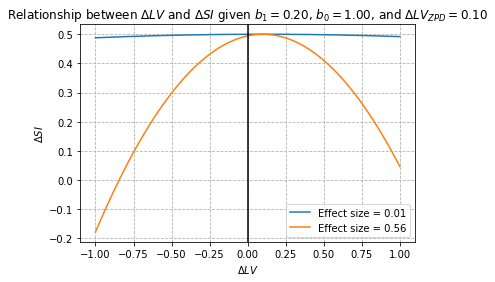

In [24]:
ground_truth = {}

# Graph to demonstrate relationship between scoreImprovement and learnerVideoScoreDifference
ground_truth['x'] = np.arange(-1, 1.01, 0.01)
ground_truth['y'] = learnerVideoScoreToScoreImprovement(ground_truth['x'], 0.01)
fig = plt.plot(ground_truth['x'], ground_truth['y'], label='Effect size = 0.01')
plt.plot(ground_truth['x'], learnerVideoScoreToScoreImprovement(ground_truth['x'], 0.56), label='Effect size = 0.56')

plt.grid(b=True, which='both', axis='both', linestyle='--')
plt.axvline(0, color='black')
plt.xlabel('$\Delta LV$')
plt.ylabel('$\Delta SI$')
plt.legend(loc='best')
ax = plt.title('Relationship between $\Delta LV$ and $\Delta SI$ given $b_1 = $%.2f, $b_0 = $%.2f, and $\Delta LV_{ZPD} = $%.2f' % (es, delta_score_range['max'], zpd))

1) Simulate data for video discrepancy/randomly sample from a distribution. I think a uniform distribution may be most fitting. This is because we are assigning the videos given to participants uniformly (so it would be split 33/33/33 across Amateur, Intermediate, and Expert groups). Whilst we are sampling players with fewer hours, I'd still probably go with a score improvement uniformly distributed between [-1,1]. We can always test with a normal distribution skewed towards a positive mean, but the uniform distribution is the more conservative estimate.

2) Then, from this data, simulate the score improvement using a function relating video discrepancy to score improvement. In our case, the function would be a quadratic, but we don't have a good idea as to what shape it will take. However, we can define a shape based on the SEOI (since the coefficient is the amount of curvature => the difference between the peak/off-peak) and even play around with different distributions.

3) Add some random noise to the score improvement using a normal distribution with a mean of 0 (since we'll have the improvement score already) and a variance of some value we can then change and see how it impacts power.

4) Run the statistical test on the data (curve fitting a quadratic and then calculating significance) and record whether the result is significant. Here we use an Ordinary Least Squares model to fit a second degree polynomial curve to the data. We use Ordinary Least Squares as we are running a second order polynomial *linear* regression (since we do not expect any covariance between coefficients).

F = 0.08879796702352315
F2 = 8.702200768305268
0.08155596328515623


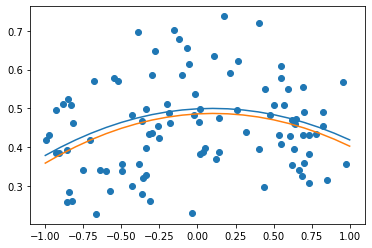

4.306701400640836


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     4.307
Date:                Wed, 23 Jun 2021   Prob (F-statistic):             0.0161
Time:                        14:49:08   Log-Likelihood:                 78.934
No. Observations:                 100   AIC:                            -151.9
Df Residuals:                      97   BIC:                            -144.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4860      0.017     28.636      0.000       0.452       0.520
x              0.0218      0.020      1.098      0.275      -0.018       0.061
I(x ** 2)     -0.1050      0.040     -2.607      0.011      -0.185      -0.025
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.825
Skew:                           0.189   Prob(JB):                        0.402
Kurtosis:                       2.457   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
x = uniformDistributionSample(delta_score_range['min'], delta_score_range['max'], 100)
y = learnerVideoScoreToScoreImprovement(x, 0.1) + np.random.normal(0, 0.1, 100)

df = pd.DataFrame(columns=['y','x'])
df['x'] = x
df['y'] = y

weights = np.polyfit(x,y, 2)
#print(weights)
model = np.poly1d(weights)
#print(model)

yhat = model(x)
ybar = np.sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((y - ybar)**2)
sserr = np.sum((y-yhat)**2)

msreg = ssreg / (len(y)-2-1)
mserr = sserr / (len(y)-2-1)

DFM = 2-1
DFE = 100 - 2
DFT = 100 - 1

msreg2 = ssreg / DFM
mserr2 = sserr / DFE
mstot2 = sstot / DFT

F = msreg / mserr
F2 = msreg2 / mserr2

print("F = " + str(F))
print("F2 = " + str(F2))

determination = ssreg/sstot

print(determination)

results = smf.ols(formula='y ~ x + I(x**2)', data=df).fit()
p = results.params

x_plot = np.arange(-1.0, 1.1, 0.1)
fig = plt.subplot()
plt.plot(x_plot, learnerVideoScoreToScoreImprovement(x_plot,.1))
plt.plot(x_plot, p[0] + p[1] * x_plot + p[2] * (x_plot ** 2))

plt.scatter(x,y)
plt.show()


F = results.mse_model / results.mse_resid

print(F)

results.summary()

In [59]:
sample_data = powerAnalysisPolynomialRegression(polynomialModelAndSignificance, n, N,
                                               playerVideoDistributionSample, learnerVideoScoreToScoreImprovement,
                                               effect_size=0.2, degree=2, significance=significance, residual_std=0.1,
                                               value_range=delta_score_range, show_progress_bar=True)

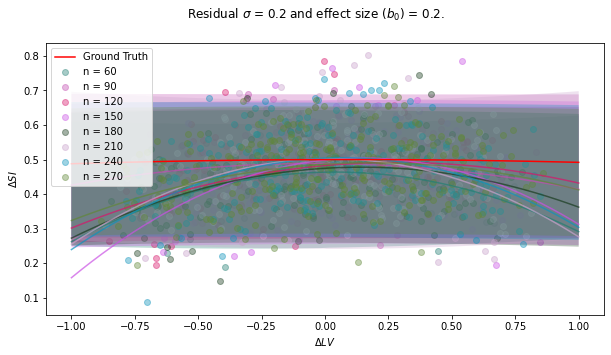

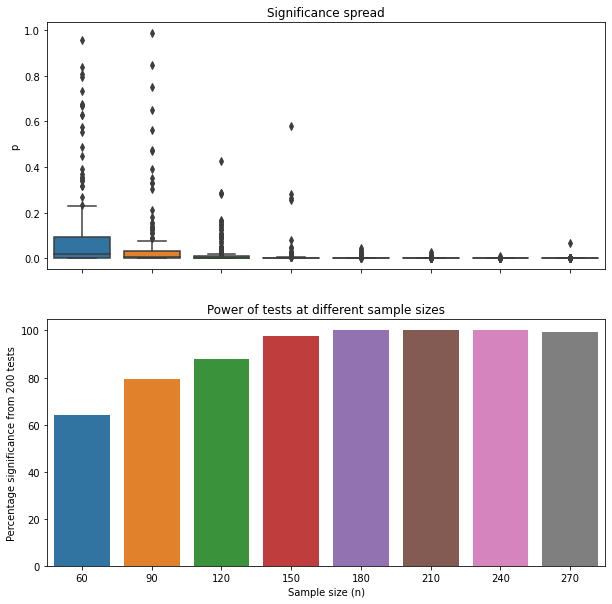

In [60]:
plotPowerAnalysisData(sample_data, 0.2, 0.2, ground_truth, n, N)

In [2]:
# Messy as fuck, but optimised so I don't generate samples for all sample sizes, just enough to find the lowest
# size that meets the power provided
def findLowestSampleSizeMeetingPower(power, residual_range, effect_size_range, sample_size_distribution,
                                     number_of_samples, significance, value_range, degree=2):  
    data = pd.DataFrame(columns=residual_range, index=effect_size_range, data=None)
    for std in tqdm(residual_range, desc="Working through std"):
        for es in tqdm(effect_size_range, desc="Working through es" ):
            for i in sample_size_distribution:
                sum_of_significant = 0
                for j in range(0,number_of_samples):
                    _, _, results = generateRegressionData(polynomialModelAndSignificance, i, playerVideoDistributionSample, 
                                                        learnerVideoScoreToScoreImprovement, es, degree, 
                                                        std, value_range)
                    sum_of_significant += 1 if results.f_pvalue <= significance else 0
                if sum_of_significant / number_of_samples * 100 >= power:
                    data[es][std] = i
                    break            
    return data

data = findLowestSampleSizeMeetingPower(90, 0.01*np.arange(1, 24, 2), 0.01*np.arange(1, 24, 2), n, N, 0.05, delta_score_range)
data.to_csv("stdresidualesdata.csv", index=True)

Text(0.5, 114.0, 'Effect Size')

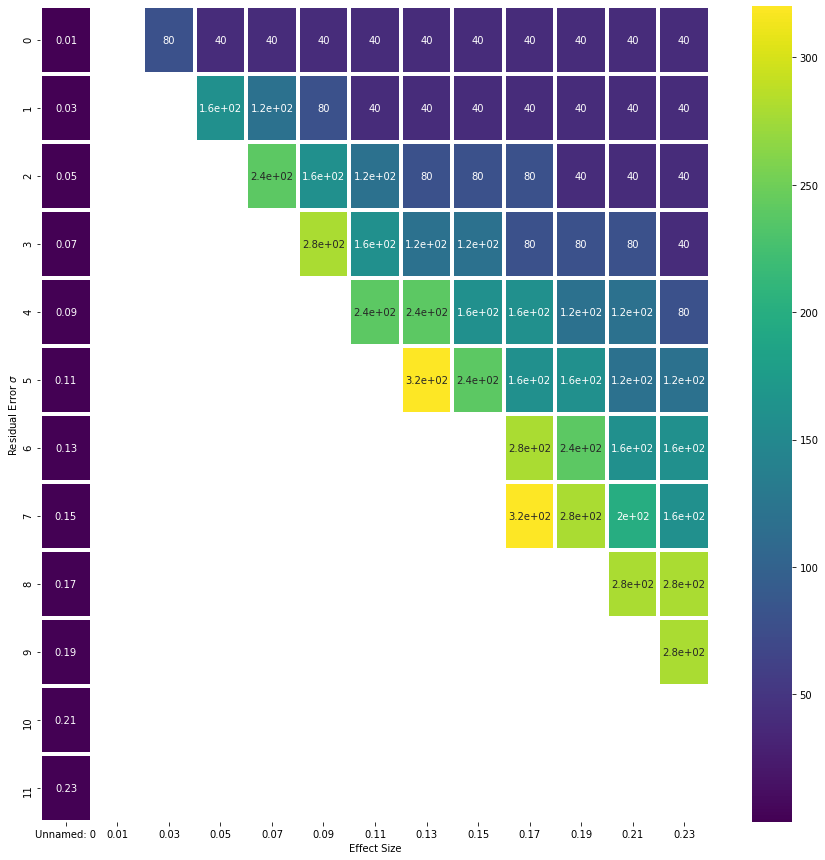

In [3]:
data = pd.read_csv('stdresidualesdata.csv')
data = data.astype(float)
fig, ax3 = plt.subplots(figsize = (15,15))

sns.heatmap(data, annot=True, linewidths=4, cmap='viridis')
ax3.set_ylabel('Residual Error $\sigma$')
ax3.set_xlabel('Effect Size')